In [1]:
library(IRdisplay)

display_html(
'<script>  
code_show=true; 
function code_toggle() {
  if (code_show){
    $(\'div.input\').hide();
  } else {
    $(\'div.input\').show();
  }
  code_show = !code_show
}  
$( document ).ready(code_toggle);
</script>
  <form action="javascript:code_toggle()">
    <input type="submit" value="Click here to toggle on/off the raw code.">
 </form>'
)

In [3]:
library(brms)
library(haven) # to load the SPSS .sav file
library(tidyverse) # needed for data manipulation.
library(RColorBrewer) # needed for some extra colours in one of the graphs
library(ggmcmc)
library(ggthemes)
library(ggridges)

# IMPORT VISUALIZATION LIBRARIES:
library(data.table)
library(ggplot2)
library(ggridges)
library(dplyr)
library(tidyr)
library(scales)
library(viridis)

In [4]:
df <- read.table('uncon_v_con_shock_MR_ROI24_mean_of_trial_by_trial.txt',header = TRUE)
head(df)

,Pair,ROI,Y,TRAITmean,TRAITdiff,STATEmean,STATEdiff,BPdiff_stdz
,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,P00,ACC,0.2127,-1.003,-0.0406,-1.2307,-0.1812,-0.8664
2,P00,Amygdala_BLBM_La_L,0.0293,-1.003,-0.0406,-1.2307,-0.1812,-0.8664
3,P00,Amygdala_BLBM_La_R,-0.1446,-1.003,-0.0406,-1.2307,-0.1812,-0.8664
4,P00,Amygdala_CeME_L,-0.0976,-1.003,-0.0406,-1.2307,-0.1812,-0.8664
5,P00,Amygdala_CeME_R,-0.0114,-1.003,-0.0406,-1.2307,-0.1812,-0.8664
6,P00,PCC1,0.0773,-1.003,-0.0406,-1.2307,-0.1812,-0.8664


# **1. Bayesian Multi-level modeling**

## **Model 1: Varying intercept and varying slope model.**
ROIs will have varying intercepts and varying slopes for every independent variable.

$$Y \sim Student\_t(\nu,\mu_{s,r},\sigma^{2}_{\epsilon})$$  
$$\mu_{s,r} = \alpha + \alpha_{SUB} + \alpha_{ROI} + (\beta_{TM}+\beta_{ROI_{TM}})*TM + (\beta_{TD}+\beta_{ROI_{TD}})*TD + (\beta_{SM}+\beta_{ROI_{SM}})*SM + (\beta_{SD}+\beta_{ROI_{SD}})*SD + (\beta_{BPD}+\beta_{ROI_{BPD}})*BPD \epsilon$$

## **Priors**
$$\alpha \sim Student\_t(3,0,10)$$
$$\alpha_{SUB} \sim Student\_t(\nu_{SUB},0,\sigma_{SUB})$$
$$\sigma_{SUB} \sim Student\_t(3,0,10)$$
$$\nu_{SUB} \sim \Gamma(3.325,0.1)$$
$$\alpha_{ROI} \sim Student\_t(\nu_{ROI},0,\sigma_{ROI})$$
$$\sigma_{ROI} \sim Student\_t(3,0,10)$$
$$\nu_{ROI} \sim \Gamma(3.325,0.1)$$
$$\beta_{TM} \sim Student\_t(3,0,10)$$
$$\beta_{TD} \sim Student\_t(3,0,10)$$
$$\beta_{SM} \sim Student\_t(3,0,10)$$
$$\beta_{SD} \sim Student\_t(3,0,10)$$
$$\beta_{BPD} \sim Student\_t(3,0,10)$$
$$\beta_{ROI_{TM}} \sim Student\_t(3,0,10)$$
$$\beta_{ROI_{TD}} \sim Student\_t(3,0,10)$$
$$\beta_{ROI_{SM}} \sim Student\_t(3,0,10)$$
$$\beta_{ROI_{SD}} \sim Student\_t(3,0,10)$$
$$\beta_{ROI_{BPD}} \sim Student\_t(3,0,10)$$

$$\nu \sim \Gamma(3.325,0.1)$$
$$\sigma_{\epsilon} \sim Student\_t(3,0,10)$$

Where,  
TM: Trait mean  
TD: Triat difference  
SM: State mean  
SD: State difference  
BPD: button press difference  


In [5]:
mod = '1 + STATEmean + TRAITmean + STATEdiff + TRAITdiff + BPdiff_stdz'
modelForm = paste('Y ~',mod,'+ (1 | gr(Pair, dist= "student")) + (',mod,'| gr(ROI, dist="student"))')
priorRBA <- get_prior(formula = modelForm,data=df,family = 'student')
priorRBA$prior[2:6] <- "student_t(3,0,10)"
priorRBA$prior[9:10] <- "gamma(3.325,0.1)"
priorRBA$prior[12] <- "gamma(3.325,0.1)"
priorRBA

,prior,class,coef,group,resp,dpar,nlpar,bound
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,,b,,,,,,
2,"student_t(3,0,10)",b,BPdiff_stdz,,,,,
3,"student_t(3,0,10)",b,STATEdiff,,,,,
4,"student_t(3,0,10)",b,STATEmean,,,,,
5,"student_t(3,0,10)",b,TRAITdiff,,,,,
6,"student_t(3,0,10)",b,TRAITmean,,,,,
7,lkj(1),cor,,,,,,
8,,cor,,ROI,,,,
9,"gamma(3.325,0.1)",df,,Pair,,,,


In [6]:
iterations <- 10000
chains <- 4
SCALE <- 1
ns <- iterations*chains/2


qVars = 'STATEmean,TRAITmean,STATEdiff,TRAITdiff,BPdiff_stdz'
EOI = 'Intercept,STATEmean,TRAITmean,STATEdiff,TRAITdiff,BPdiff_stdz'
EOIq <- strsplit(qVars, '\\,')[[1]]
if(!('Intercept' %in% EOIq)) EOIq <- c('Intercept', EOIq)
EOIq <- intersect(strsplit(EOI, '\\,')[[1]], EOIq)
EOIq


dataTable <- df

# number of ROIs
nR <- nlevels(dataTable$ROI)

# number of sigfigs to show on the table
nfigs <- 4

head(dataTable)

[1] "Intercept"   "STATEmean"   "TRAITmean"   "STATEdiff"   "TRAITdiff"  
[6] "BPdiff_stdz"

,Pair,ROI,Y,TRAITmean,TRAITdiff,STATEmean,STATEdiff,BPdiff_stdz
,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,P00,ACC,0.2127,-1.003,-0.0406,-1.2307,-0.1812,-0.8664
2,P00,Amygdala_BLBM_La_L,0.0293,-1.003,-0.0406,-1.2307,-0.1812,-0.8664
3,P00,Amygdala_BLBM_La_R,-0.1446,-1.003,-0.0406,-1.2307,-0.1812,-0.8664
4,P00,Amygdala_CeME_L,-0.0976,-1.003,-0.0406,-1.2307,-0.1812,-0.8664
5,P00,Amygdala_CeME_R,-0.0114,-1.003,-0.0406,-1.2307,-0.1812,-0.8664
6,P00,PCC1,0.0773,-1.003,-0.0406,-1.2307,-0.1812,-0.8664


In [7]:
fm <- brm(modelForm,
          data=dataTable,
          chains = chains,
          family = 'student',
          prior = priorRBA,
          inits=0, iter=iterations, 
          control = list(adapt_delta = 0.99, max_treedepth = 15))

Compiling the C++ model

Start sampling




SAMPLING FOR MODEL 'b3870dc0a6d10a25eb10fb783a50fa1a' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 10000 [  0%]  (Warmup)
Chain 1: Iteration: 1000 / 10000 [ 10%]  (Warmup)
Chain 1: Iteration: 2000 / 10000 [ 20%]  (Warmup)
Chain 1: Iteration: 3000 / 10000 [ 30%]  (Warmup)
Chain 1: Iteration: 4000 / 10000 [ 40%]  (Warmup)
Chain 1: Iteration: 5000 / 10000 [ 50%]  (Warmup)
Chain 1: Iteration: 5001 / 10000 [ 50%]  (Sampling)
Chain 1: Iteration: 6000 / 10000 [ 60%]  (Sampling)
Chain 1: Iteration: 7000 / 10000 [ 70%]  (Sampling)
Chain 1: Iteration: 8000 / 10000 [ 80%]  (Sampling)
Chain 1: Iteration: 9000 / 10000 [ 90%]  (Sampling)
Chain 1: Iteration: 10000 / 10000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 668.54 seconds (Warm-up)
Chain 1:                678.79 seconds (Sampling)


Warning message:
“Tail Effective Samples Size (ESS) is too low, indicating posterior variances and tail quantiles may be unreliable.
Running the chains for more iterations may help. See
http://mc-stan.org/misc/warnings.html#tail-ess”


In [8]:
cat(capture.output(summary(fm)),sep = '\n', append=TRUE)

 Family: student 
  Links: mu = identity; sigma = identity; nu = identity 
Formula: Y ~ 1 + STATEmean + TRAITmean + STATEdiff + TRAITdiff + BPdiff_stdz + (1 | gr(Pair, dist = "student")) + (1 + STATEmean + TRAITmean + STATEdiff + TRAITdiff + BPdiff_stdz | gr(ROI, dist = "student")) 
   Data: dataTable (Number of observations: 1464) 
Samples: 4 chains, each with iter = 10000; warmup = 5000; thin = 1;
         total post-warmup samples = 20000

Group-Level Effects: 
~Pair (Number of levels: 61) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
df               33.00     18.81     7.52    79.06 1.00      411      392
sd(Intercept)     0.26      0.03     0.21     0.33 1.00     2194     1779

~ROI (Number of levels: 24) 
                           Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS
df                            35.36     18.46     9.36    79.77 1.01      871
sd(Intercept)                  0.09      0.02     0.05     0.14 1.00     7159
sd(STATEmean)  

In [9]:
# Extract posteriors for fixed (aa) and random effects (bb)
aa <- fixef(fm, summary = FALSE)/SCALE # Population-Level Estimates
bb <- lapply(ranef(fm, summary = FALSE), `/`, SCALE) # Extract Group-Level (or random-effect)

### Functions

In [15]:
# Following functions add the "the poaterior of the global intercept with the intercept posterior of each roi"
# bb[['ROI']][,,tm] is a matrix with columns containing posteriors for every ROI
# aa[,tm] is a single column posterior for the global intercept.
psROI <- function(aa, bb, tm) {
  ps <- apply(bb[['ROI']][,,tm], 2, '+', aa[,tm])
  return(ps)
}
# apply(X,axis,func,..)
# check help for apply (?apply)


# compute P+
cnt <- function(x, ns) return(sum(x>0)/ns)
# summary for ROIs: nd - number of digits to output
sumROI <- function(R0, ns, nd) {
  hubs <- data.frame(cbind(apply(R0, 2, mean), apply(R0, 2, sd), apply(R0, 2, cnt, ns), t(apply(R0, 2, quantile, 
      probs=c(0.025, 0.05, 0.5, 0.95, 0.975)))))
  names(hubs) <- c('mean', 'SD', 'P+', '2.5%', '5%', '50%', '95%', '97.5%')
  return(round(hubs,nd))
}

################################# conventional GLM ############################################
sumGLM <- function(ll, tm, nR, DF, nd) {
   th <- qt(c(0.025, 0.05, 0.5, 0.95, 0.975), DF)
   rr <- matrix(0, nrow = nR, ncol = 8, dimnames=list(levels(dataTable$ROI), c('mean', 'SD', '2-sided-p', '2.5%', '5%', '50%', '95%', '97.5%')))
   rownames(rr) <- levels(dataTable$ROI)
   if(tm == 'Intercept') tm <- '(Intercept)'
   for(ii in 1:nR) {
     u1 <- ll[[ii]]$coefficients[tm,1] # mean
     u2 <- ll[[ii]]$coefficients[tm,2] # sd
     u3 <- ll[[ii]]$coefficients[tm,4] # 2-sided p
     rr[ii,] <- round(c(u1, u2, u3, u1+u2*th),nd)
   } 
   return(rr)
}

################################# function to plot posteriors ##################################
plotPDP <- function(ps0,gg_brm,gg_glm){
rois <- colnames(ps0) # Global intercept + ROI intercepts
nobs=dim(ps0)[1] # gets number of rows and assigns it to nobj

# initialize a single column dataframe with number of row equal to number of rois
data_stats = data.frame(1:length(rois)) 
data_stats$ROI <- rois # adds an ROI column with roi names

#data_stats$mean <- colMeans(data)
data_stats$brmMean <- gg_brm$mean # Adds a brmMean columns
data_stats$glmMean <- gg_glm$mean # Adds a brmMean columns

# gets proportion of the posterior greater than 0 for each roi
data_stats$P <- colSums(ps0 > 0)/nobs 
# gets proportion of the posterior less than 0
#data_stats$Pn <- 1 - data_stats$P
data_stats$Pn <- data_stats$P
for (i in 1:length(rois)) {
  if (data_stats$P[i]<.5){data_stats$Pn[i]=1-data_stats$P[i]}
}

# this will order the distributions correctly
#data_stats <- data_stats[order(data_stats$brmMean),]
data_stats <- data_stats[order(data_stats$P),]

data_trans <- as.data.frame(t(as.matrix(ps0)))
data_trans <- tibble::rownames_to_column(data_trans, "ROI")
data_trans$X <- 1:nrow(data_trans)

# merge values & stats into one table by ROI
data_merge <- merge(data_stats, data_trans, by = "ROI")
data_merge <- data_merge[order(data_merge$X),]

# Transform data into long form
# Melt dataframe by ROI
library(data.table)

data_long <- melt(data_trans, id=c("ROI","X"))
data_long <- data_long[order(data_long$X),]

# This is incredibly clunky, but for the sake of time adding stats by ensuring orders are all the same and repeating each value 2000 times... Tried a few different methods with no success for some reason. 

data_long$brmMean <- rep(data_merge$brmMean, each = nobs)
data_long$glmMean <- rep(data_merge$glmMean, each = nobs)
data_long$P <- rep(data_merge$P, each =nobs)
data_long$Pn <- rep(data_merge$Pn, each =nobs)

# set your labels here so you don't have to change within the plot below: 
format(round(1, 2), nsmall = 2)

y.axis.labs <- format(round(data_stats$P,3), nsmall = 2)                        # y axis labels
sec.y.axis.labs <- data_stats$ROI                             # second y axis labels (probabilities)

 # X AXIS LABELS NEED TO CHANGE TO CORRESPOND TO DATA SET! UNCOMMENT WHICHEVER MATCHES

# Uncomment for THREAT
x.axis.labs <- c( "control > uncontrol", "0", "uncontrol > control")                 # x axis labels  THREAT
x.labs.pos <- c(-0.25, 0, 0.25)                                             # x axis position THREAT

#graph.title <- data.name                                   # graph title 
legend.title <- "Probability"                              # legend title
y.axis.title <- NULL                                       # for now ...
x.axis.title <- NULL                                       # for now...

# GRAPH DATA
library(repr)
options(repr.plot.width=10,repr.plot.height=8)

dataset <- data_long
x.values <- data_long$value                               # x values
y.values <- data_long$ROI                                 # y values
y.values.RO <- data_long$value                            # values to reorder Y by
distrib.fill <- data_long$Pn                              # fill graph with probabilities
group <- data_long$ROI

# Other aspects
gradient.colors <- c("yellow","#C9182B","#41245C")        # change gradient colors here (currently, yellow - purple)
label.size <- 16                                         # adjust ROI and probability y-axis font size
title.size <- 32                                         # adjust graph title size 
x.axis.size <- 16                                        # adjust x-axis label sizes

# here is where you can change information about the graph and add other characteristics using ggplot and ggridges


ggplot(dataset, aes(x = x.values, y = as.numeric(reorder(y.values, y.values.RO)), 
                    fill = distrib.fill, group = group)) +                      # scale = spacing, alpha = transparency
  coord_cartesian(xlim = c(-0.5, 0.5)) +
  stat_density_ridges(quantile_lines = TRUE, 
                      quantiles = 2, 
                      alpha = .95, 
                      scale = 1,
                      color = "black",
                      size = .35
                     ) +
    geom_segment(aes(x = glmMean, xend = glmMean, y = as.numeric(reorder(y.values, y.values.RO)),
                                      yend = as.numeric(reorder(y.values, y.values.RO))+0.9), color = "red") +           # divide into two quantiles (show mean)
  geom_vline(xintercept = 0, linetype="solid",color = "black",alpha = .95, size = .45) +    #create line at X = 0
  scale_fill_gradientn(colors = viridis_pal(direction = 1, option = "inferno")(20),                         # set gradient
                       limits = c(.85,1),                                # which probabilites matter?
                       na.value = "#909497",                                # if not in limits, gray out
                       name = legend.title) +                            # name legend
  scale_y_continuous(breaks = 1:length(rois),                            # A VERY HACK-Y WAY TO HAVE TWO Y AXES W DISCRETE DATA
                     expand = c(0,0),
                     labels = y.axis.labs,                               # Trick ggplot into thinking data is continuous...
                     sec.axis = sec_axis(~.,                             # Second axis to show probabilities
                                         breaks = 1:length(rois),
                                         labels = sec.y.axis.labs)) +
  #theme_ridges(font_size = label.size, grid = TRUE, center_axis_labels = TRUE) +  # theme info
  #ggtitle(graph.title)+ 
  #theme_bw() +# graph title
 #theme_ridges(grid = FALSE) + 
  theme(   
    panel.background = element_blank(),
    #legend.position = "none",
    #panel.grid.major.y = element_line(color = "grey"), 
    plot.title = element_text(hjust = 0.5, size = title.size),            # plot title size and position
    axis.text.y = element_text(size=label.size),                               # y-axis text size
    axis.line.x = element_line(color = "gray"),
    axis.text.y.right = element_text(size = label.size),                  # y-axis info for right axis
    axis.text.x = element_text(size = x.axis.size),
    #plot.margin = unit(c(0,0,0,0), "cm"),
    axis.ticks.x = element_blank(),
    axis.ticks.y = element_blank(),
    legend.title.align = 5)+
  guides(shape = guide_legend(label.position = "bottom",
                              title.positon = "bottom",
                              title.vjust = 0.4)) +          
  labs(
    x = NULL,                                                         # Add or not add X and Y labels
    y = NULL) +
  scale_x_continuous(breaks = x.labs.pos, labels = c(x.axis.labs))
}

# **2. BML and GLM Summaries with Posterior Plots**

===== Summary of region effects for Intercept (RBA results) =====
                      mean     SD     P+    2.5%      5%     50%    95%  97.5%
ACC                 0.0491 0.0570 0.8066 -0.0618 -0.0439  0.0493 0.1435 0.1611
Amygdala_BLBM_La_L  0.0665 0.0606 0.8655 -0.0536 -0.0329  0.0665 0.1654 0.1853
Amygdala_BLBM_La_R  0.0926 0.0595 0.9418 -0.0263 -0.0048  0.0930 0.1895 0.2082
Amygdala_CeME_L     0.1344 0.0630 0.9838  0.0101  0.0312  0.1340 0.2388 0.2598
Amygdala_CeME_R     0.1018 0.0635 0.9490 -0.0212 -0.0006  0.1008 0.2079 0.2288
lBNST               0.2246 0.0707 0.9996  0.0924  0.1115  0.2233 0.3438 0.3667
lCa                 0.1482 0.0553 0.9964  0.0413  0.0570  0.1484 0.2384 0.2553
ldAI                0.1954 0.0615 0.9993  0.0763  0.0944  0.1952 0.2966 0.3167
lPa                 0.0902 0.0545 0.9515 -0.0163  0.0008  0.0899 0.1808 0.1982
lPAG                0.0402 0.0594 0.7494 -0.0778 -0.0583  0.0405 0.1373 0.1569
lPI                 0.0401 0.0588 0.7531 -0.0744 -0.0569  0.0397 

Warning message in melt(data_trans, id = c("ROI", "X")):
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(data_trans). In the next version, this warning will become an error.”
Picking joint bandwidth of 0.00766



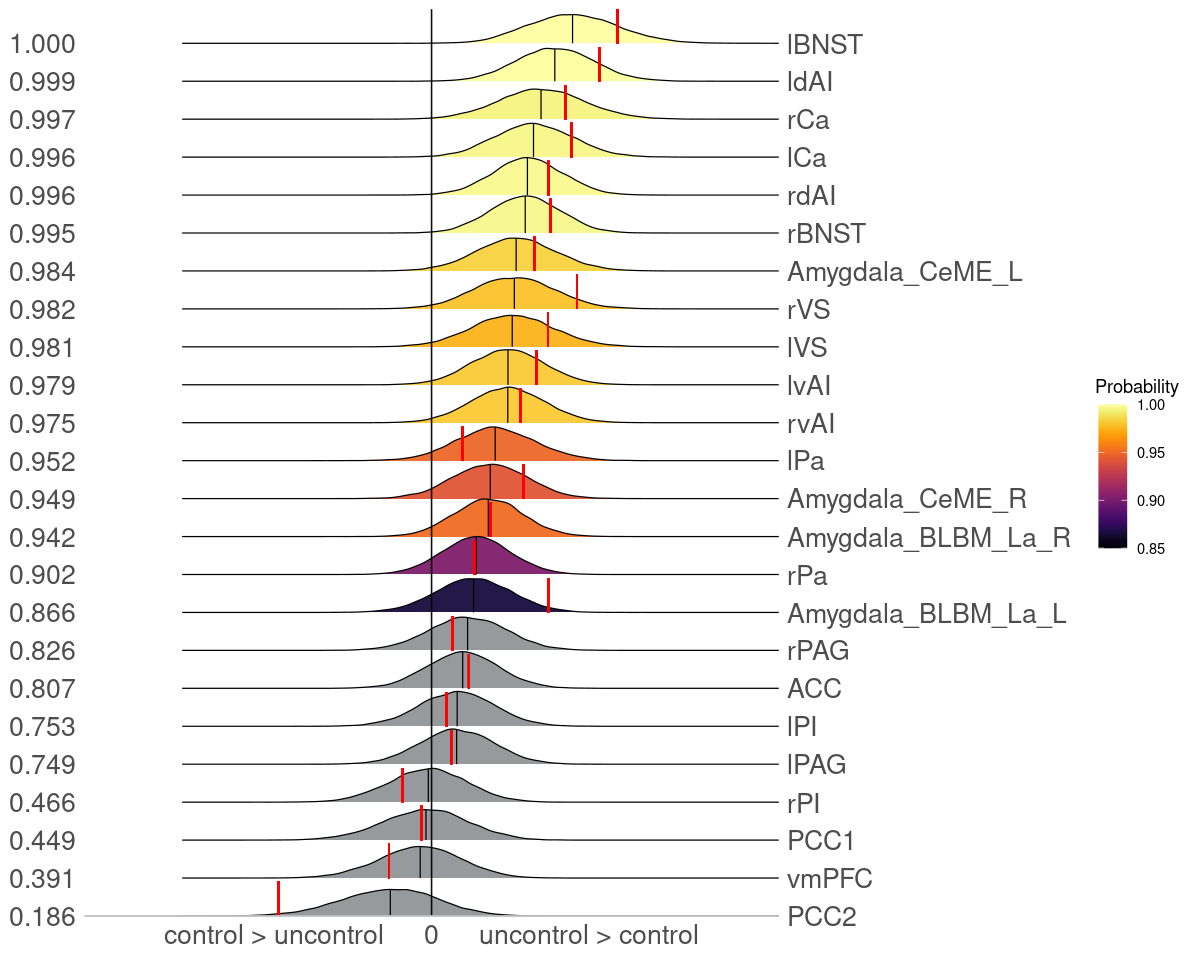

In [16]:
# for Intercept and quantitative variables
ii = 1
cat(sprintf('===== Summary of region effects for %s (RBA results) =====', EOIq[ii]), sep = '\n', append=TRUE)
ps0 <- psROI(aa, bb, EOIq[ii])
gg_brm <- sumROI(ps0, ns, nfigs)
#gg_brm$ROI <- factor(rownames(gg_brm))
cat(capture.output(gg_brm), sep = '\n', append=TRUE)

cat(sprintf('=================================================================================================================='),sep='\n')
cat(sprintf('===== Summary of region effects under GLM for %s (for reference only): no adjustment for multiplicity =====', EOIq[ii]),sep = '\n', append=TRUE)
mm <- list()
GLM <- as.formula(paste('Y ~ ',mod))
if(SCALE!=1) dataTable$Y <- (dataTable$Y)/SCALE  # scale back for GLM
for(kk in levels(dataTable$ROI)) mm[[kk]] = lm(GLM, data=dataTable[dataTable$ROI==kk,])
nn <- lapply(mm, summary)
ll <- lapply(nn, `[`, 'coefficients')
gg_glm <- sumGLM(ll, EOIq[ii], nR, nn[[ii]]$df, nfigs)
gg_glm = as.data.frame(gg_glm)
cat(capture.output(gg_glm),sep = '\n', append=TRUE)

cat(sprintf('======================================== Posteriors for %s ====================================================',EOIq[ii],sep='\n'))
plotPDP(ps0,gg_brm,gg_glm)

Red vertical lines: GLM

===== Summary of region effects for BPdiff_stdz (RBA results) =====
                      mean     SD     P+    2.5%      5%     50%    95%  97.5%
ACC                 0.0494 0.0511 0.8370 -0.0469 -0.0313  0.0478 0.1367 0.1548
Amygdala_BLBM_La_L  0.0407 0.0510 0.7938 -0.0559 -0.0411  0.0392 0.1274 0.1462
Amygdala_BLBM_La_R  0.0402 0.0501 0.7908 -0.0550 -0.0394  0.0385 0.1261 0.1446
Amygdala_CeME_L     0.0301 0.0505 0.7262 -0.0670 -0.0518  0.0290 0.1142 0.1311
Amygdala_CeME_R     0.0465 0.0529 0.8122 -0.0521 -0.0366  0.0443 0.1370 0.1555
lBNST              -0.0127 0.0564 0.4260 -0.1314 -0.1104 -0.0100 0.0755 0.0910
lCa                 0.0016 0.0491 0.5208 -0.0964 -0.0800  0.0026 0.0802 0.0956
ldAI                0.0275 0.0498 0.7112 -0.0704 -0.0535  0.0270 0.1101 0.1267
lPa                 0.0150 0.0471 0.6281 -0.0795 -0.0623  0.0154 0.0914 0.1070
lPAG                0.0343 0.0484 0.7608 -0.0602 -0.0444  0.0341 0.1154 0.1310
lPI                 0.0311 0.0481 0.7440 -0.0625 -0.0470  0.030

Warning message in melt(data_trans, id = c("ROI", "X")):
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(data_trans). In the next version, this warning will become an error.”
Picking joint bandwidth of 0.00624



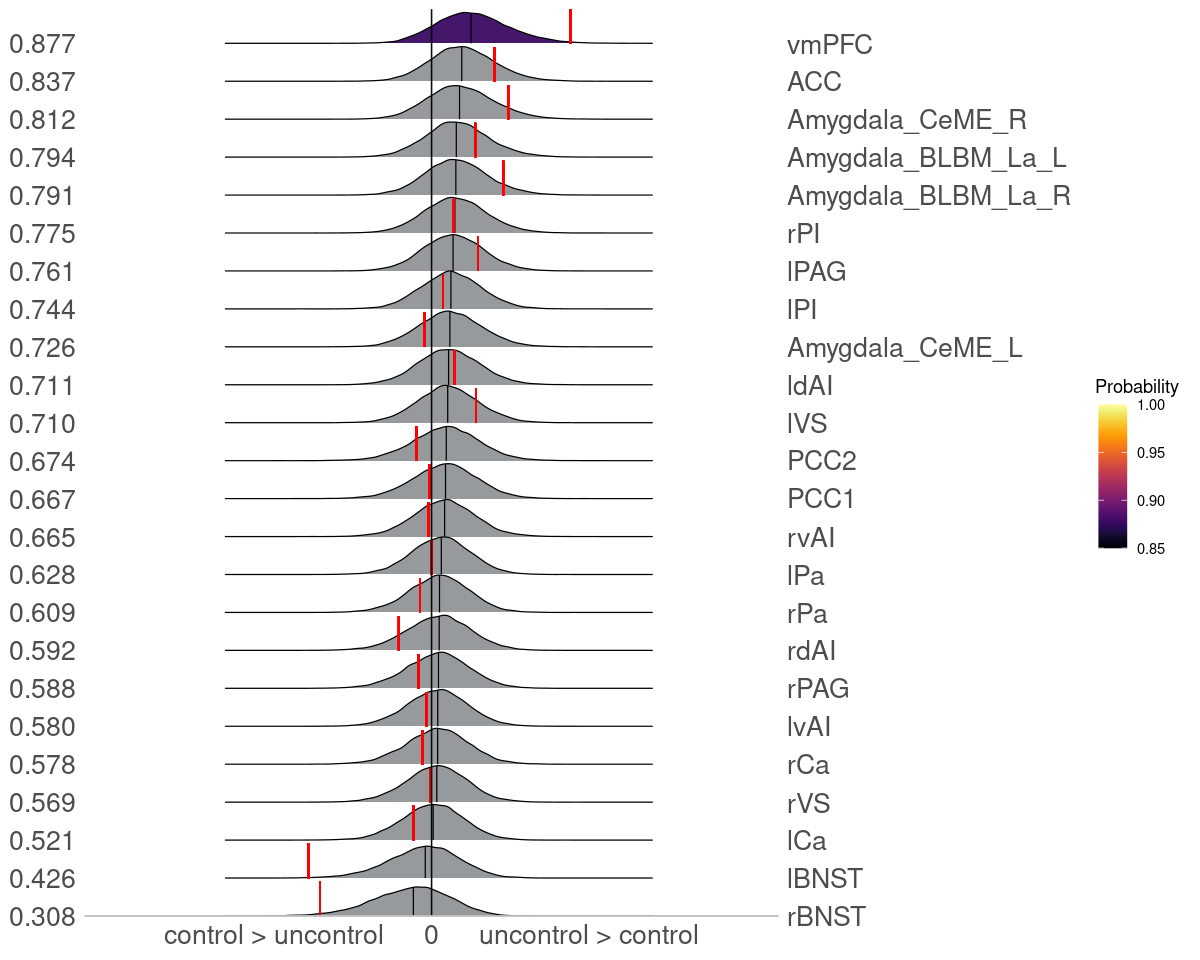

In [17]:
ii = 6
cat(sprintf('===== Summary of region effects for %s (RBA results) =====', EOIq[ii]), sep = '\n', append=TRUE)
ps0 <- psROI(aa, bb, EOIq[ii])
gg_brm <- sumROI(ps0, ns, nfigs)
#gg_brm$ROI <- factor(rownames(gg_brm))
cat(capture.output(gg_brm), sep = '\n', append=TRUE)

cat(sprintf('=================================================================================================================='),sep='\n')
cat(sprintf('===== Summary of region effects under GLM for %s (for reference only): no adjustment for multiplicity =====', EOIq[ii]),sep = '\n', append=TRUE)
mm <- list()
GLM <- as.formula(paste('Y ~ ',mod))
if(SCALE!=1) dataTable$Y <- (dataTable$Y)/SCALE  # scale back for GLM
for(kk in levels(dataTable$ROI)) mm[[kk]] = lm(GLM, data=dataTable[dataTable$ROI==kk,])
nn <- lapply(mm, summary)
ll <- lapply(nn, `[`, 'coefficients')
gg_glm <- sumGLM(ll, EOIq[ii], nR, nn[[ii]]$df, nfigs)
gg_glm = as.data.frame(gg_glm)
cat(capture.output(gg_glm),sep = '\n', append=TRUE)

cat(sprintf('======================================== Posteriors for %s ====================================================',EOIq[ii],sep='\n'))
plotPDP(ps0,gg_brm,gg_glm)

===== Summary of region effects for STATEmean (RBA results) =====
                     mean     SD     P+    2.5%      5%    50%    95%  97.5%
ACC                0.0378 0.0543 0.7638 -0.0697 -0.0524 0.0377 0.1265 0.1432
Amygdala_BLBM_La_L 0.0356 0.0547 0.7484 -0.0731 -0.0551 0.0360 0.1239 0.1416
Amygdala_BLBM_La_R 0.0342 0.0544 0.7425 -0.0752 -0.0565 0.0349 0.1216 0.1388
Amygdala_CeME_L    0.0404 0.0546 0.7755 -0.0662 -0.0497 0.0408 0.1288 0.1481
Amygdala_CeME_R    0.0299 0.0562 0.7133 -0.0848 -0.0639 0.0312 0.1195 0.1374
lBNST              0.0418 0.0563 0.7788 -0.0699 -0.0510 0.0421 0.1336 0.1529
lCa                0.0455 0.0540 0.8058 -0.0606 -0.0434 0.0455 0.1343 0.1519
ldAI               0.0317 0.0550 0.7274 -0.0798 -0.0607 0.0329 0.1203 0.1369
lPa                0.0412 0.0538 0.7852 -0.0649 -0.0467 0.0411 0.1287 0.1459
lPAG               0.0409 0.0540 0.7826 -0.0663 -0.0477 0.0410 0.1291 0.1468
lPI                0.0347 0.0545 0.7440 -0.0743 -0.0558 0.0352 0.1225 0.1399
lvAI      

Warning message in melt(data_trans, id = c("ROI", "X")):
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(data_trans). In the next version, this warning will become an error.”
Picking joint bandwidth of 0.00674



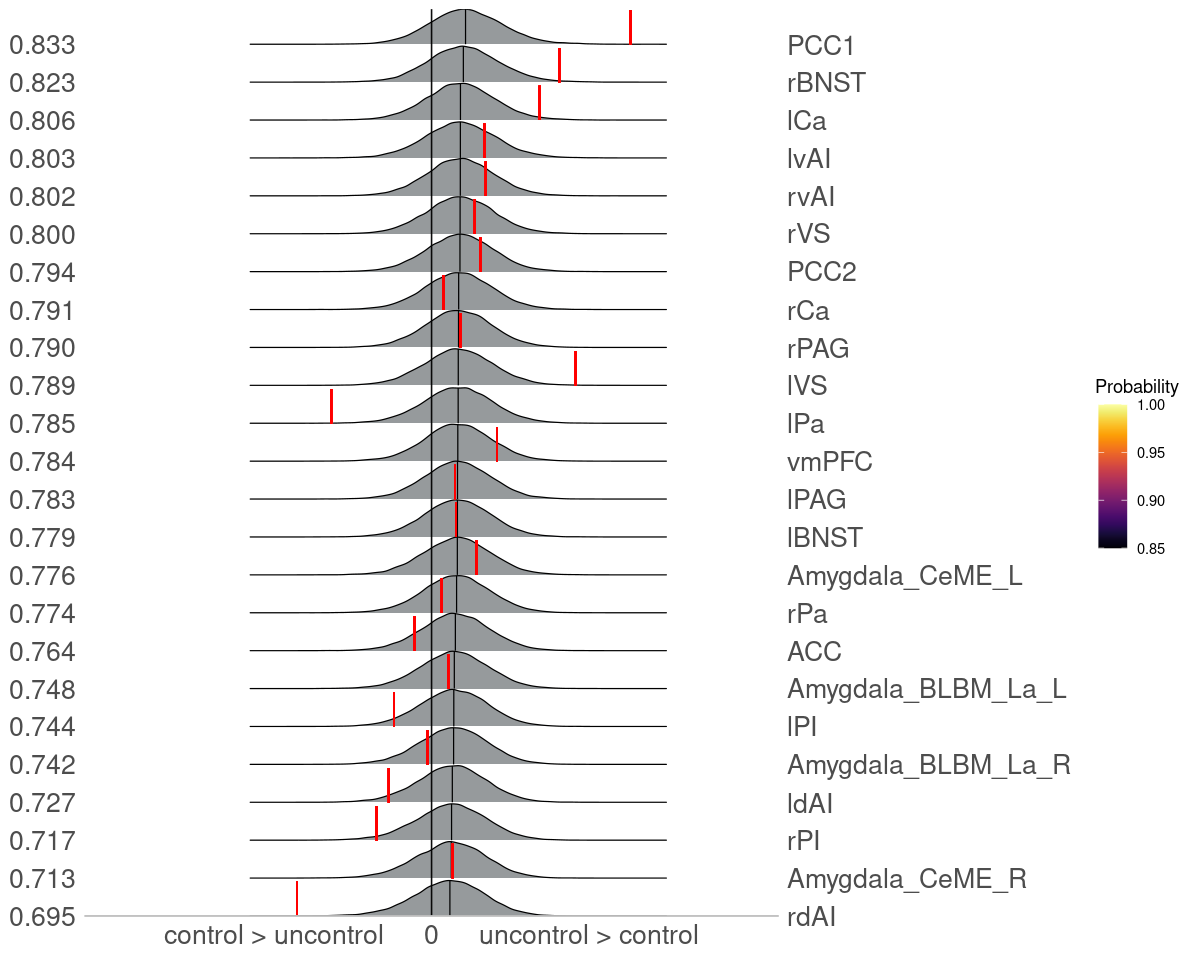

In [18]:
ii = 2
cat(sprintf('===== Summary of region effects for %s (RBA results) =====', EOIq[ii]), sep = '\n', append=TRUE)
ps0 <- psROI(aa, bb, EOIq[ii])
gg_brm <- sumROI(ps0, ns, nfigs)
#gg_brm$ROI <- factor(rownames(gg_brm))
cat(capture.output(gg_brm), sep = '\n', append=TRUE)

cat(sprintf('=================================================================================================================='),sep='\n')
cat(sprintf('===== Summary of region effects under GLM for %s (for reference only): no adjustment for multiplicity =====', EOIq[ii]),sep = '\n', append=TRUE)
mm <- list()
GLM <- as.formula(paste('Y ~ ',mod))
if(SCALE!=1) dataTable$Y <- (dataTable$Y)/SCALE  # scale back for GLM
for(kk in levels(dataTable$ROI)) mm[[kk]] = lm(GLM, data=dataTable[dataTable$ROI==kk,])
nn <- lapply(mm, summary)
ll <- lapply(nn, `[`, 'coefficients')
gg_glm <- sumGLM(ll, EOIq[ii], nR, nn[[ii]]$df, nfigs)
gg_glm = as.data.frame(gg_glm)
cat(capture.output(gg_glm),sep = '\n', append=TRUE)

cat(sprintf('======================================== Posteriors for %s ====================================================',EOIq[ii],sep='\n'))
plotPDP(ps0,gg_brm,gg_glm)

===== Summary of region effects for TRAITmean (RBA results) =====
                      mean     SD     P+    2.5%      5%     50%    95%  97.5%
ACC                -0.0410 0.0520 0.2122 -0.1413 -0.1254 -0.0415 0.0445 0.0626
Amygdala_BLBM_La_L -0.0477 0.0519 0.1777 -0.1495 -0.1325 -0.0477 0.0363 0.0540
Amygdala_BLBM_La_R -0.0443 0.0516 0.1905 -0.1441 -0.1282 -0.0444 0.0408 0.0574
Amygdala_CeME_L    -0.0482 0.0522 0.1732 -0.1492 -0.1334 -0.0484 0.0369 0.0541
Amygdala_CeME_R    -0.0439 0.0525 0.1973 -0.1453 -0.1296 -0.0444 0.0421 0.0611
lBNST              -0.0368 0.0541 0.2398 -0.1389 -0.1240 -0.0377 0.0541 0.0750
lCa                -0.0459 0.0516 0.1833 -0.1460 -0.1305 -0.0461 0.0385 0.0560
ldAI               -0.0427 0.0523 0.2042 -0.1446 -0.1278 -0.0427 0.0427 0.0609
lPa                -0.0441 0.0514 0.1922 -0.1434 -0.1280 -0.0444 0.0400 0.0572
lPAG               -0.0446 0.0517 0.1900 -0.1439 -0.1284 -0.0451 0.0401 0.0578
lPI                -0.0434 0.0519 0.1966 -0.1436 -0.1276 -0.0436 

Warning message in melt(data_trans, id = c("ROI", "X")):
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(data_trans). In the next version, this warning will become an error.”
Picking joint bandwidth of 0.00642



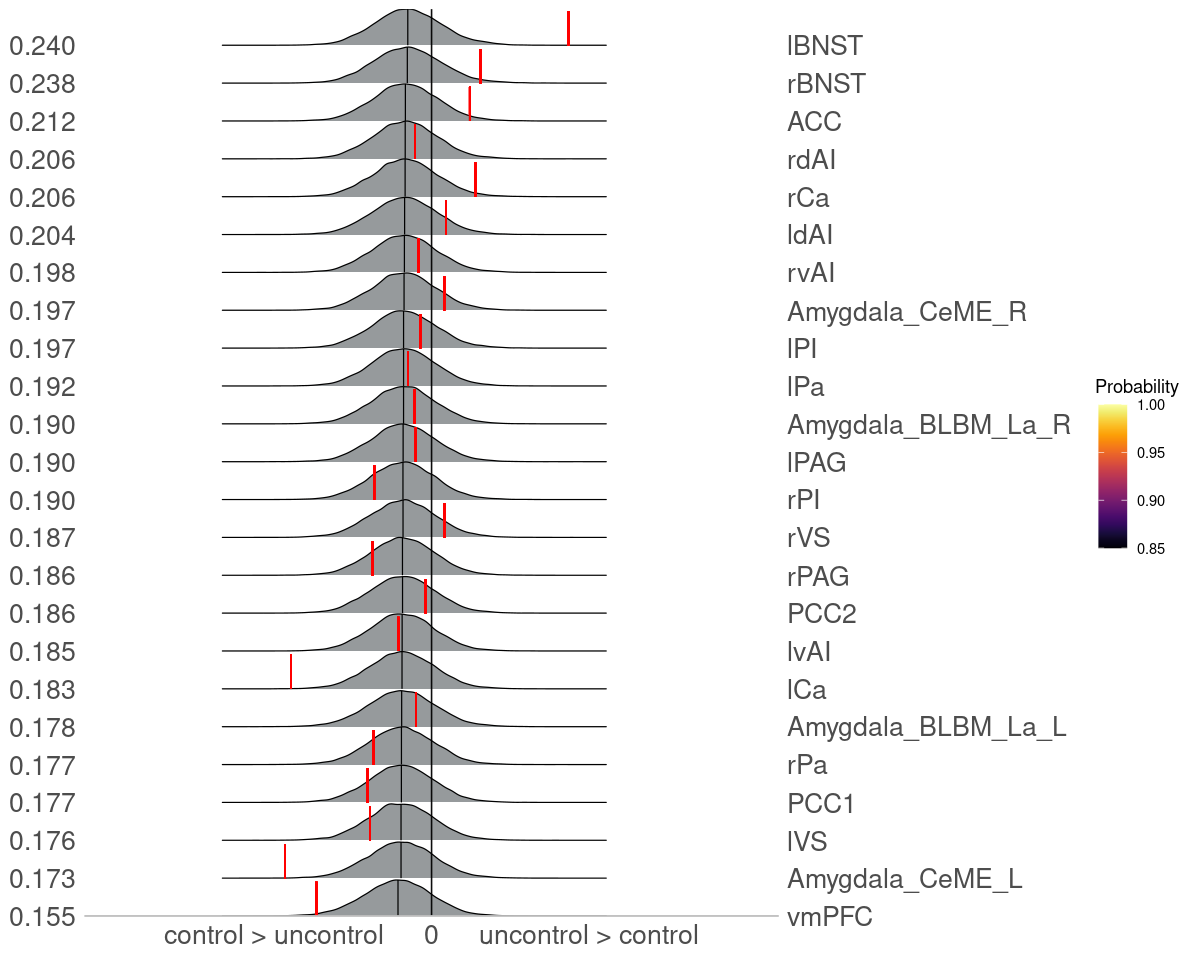

In [19]:
ii = 3
cat(sprintf('===== Summary of region effects for %s (RBA results) =====', EOIq[ii]), sep = '\n', append=TRUE)
ps0 <- psROI(aa, bb, EOIq[ii])
gg_brm <- sumROI(ps0, ns, nfigs)
#gg_brm$ROI <- factor(rownames(gg_brm))
cat(capture.output(gg_brm), sep = '\n', append=TRUE)

cat(sprintf('=================================================================================================================='),sep='\n')
cat(sprintf('===== Summary of region effects under GLM for %s (for reference only): no adjustment for multiplicity =====', EOIq[ii]),sep = '\n', append=TRUE)
mm <- list()
GLM <- as.formula(paste('Y ~ ',mod))
if(SCALE!=1) dataTable$Y <- (dataTable$Y)/SCALE  # scale back for GLM
for(kk in levels(dataTable$ROI)) mm[[kk]] = lm(GLM, data=dataTable[dataTable$ROI==kk,])
nn <- lapply(mm, summary)
ll <- lapply(nn, `[`, 'coefficients')
gg_glm <- sumGLM(ll, EOIq[ii], nR, nn[[ii]]$df, nfigs)
gg_glm = as.data.frame(gg_glm)
cat(capture.output(gg_glm),sep = '\n', append=TRUE)

cat(sprintf('======================================== Posteriors for %s ====================================================',EOIq[ii],sep='\n'))
plotPDP(ps0,gg_brm,gg_glm)

===== Summary of region effects for STATEdiff (RBA results) =====
                      mean     SD     P+    2.5%      5%     50%    95%  97.5%
ACC                -0.0120 0.0445 0.3988 -0.1024 -0.0860 -0.0111 0.0590 0.0736
Amygdala_BLBM_La_L  0.0044 0.0448 0.5360 -0.0818 -0.0678  0.0039 0.0783 0.0944
Amygdala_BLBM_La_R  0.0050 0.0440 0.5426 -0.0809 -0.0660  0.0046 0.0774 0.0926
Amygdala_CeME_L    -0.0004 0.0447 0.4974 -0.0876 -0.0732 -0.0003 0.0723 0.0864
Amygdala_CeME_R     0.0119 0.0468 0.5952 -0.0763 -0.0623  0.0108 0.0914 0.1076
lBNST               0.0154 0.0501 0.6080 -0.0779 -0.0631  0.0134 0.0998 0.1198
lCa                 0.0002 0.0435 0.5010 -0.0847 -0.0710  0.0001 0.0705 0.0852
ldAI                0.0038 0.0443 0.5311 -0.0821 -0.0681  0.0034 0.0769 0.0922
lPa                -0.0013 0.0430 0.4907 -0.0867 -0.0715 -0.0009 0.0687 0.0821
lPAG               -0.0055 0.0436 0.4514 -0.0929 -0.0775 -0.0053 0.0650 0.0795
lPI                -0.0065 0.0437 0.4463 -0.0925 -0.0785 -0.0059 

Warning message in melt(data_trans, id = c("ROI", "X")):
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(data_trans). In the next version, this warning will become an error.”
Picking joint bandwidth of 0.00555



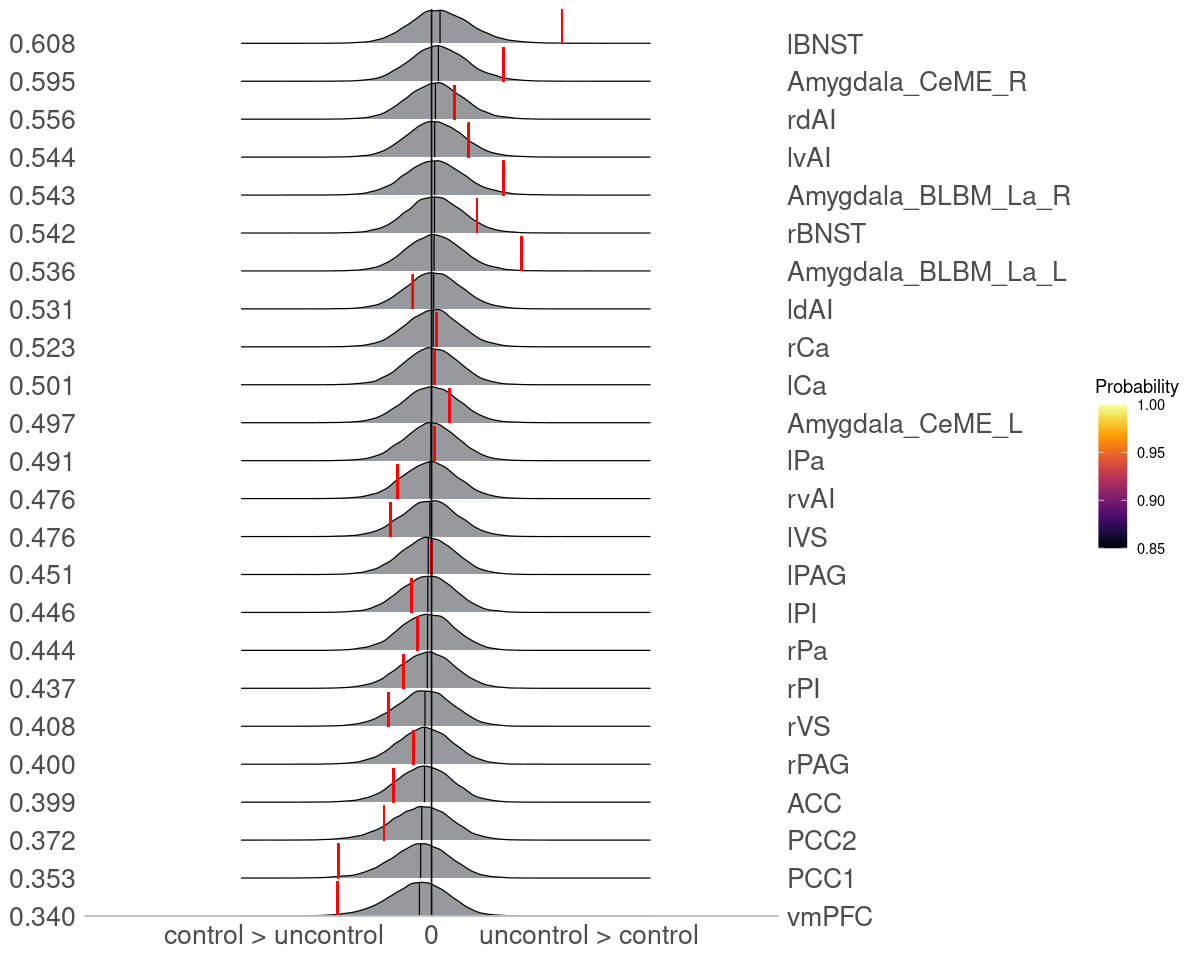

In [20]:
ii = 4
cat(sprintf('===== Summary of region effects for %s (RBA results) =====', EOIq[ii]), sep = '\n', append=TRUE)
ps0 <- psROI(aa, bb, EOIq[ii])
gg_brm <- sumROI(ps0, ns, nfigs)
#gg_brm$ROI <- factor(rownames(gg_brm))
cat(capture.output(gg_brm), sep = '\n', append=TRUE)

cat(sprintf('=================================================================================================================='),sep='\n')
cat(sprintf('===== Summary of region effects under GLM for %s (for reference only): no adjustment for multiplicity =====', EOIq[ii]),sep = '\n', append=TRUE)
mm <- list()
GLM <- as.formula(paste('Y ~ ',mod))
if(SCALE!=1) dataTable$Y <- (dataTable$Y)/SCALE  # scale back for GLM
for(kk in levels(dataTable$ROI)) mm[[kk]] = lm(GLM, data=dataTable[dataTable$ROI==kk,])
nn <- lapply(mm, summary)
ll <- lapply(nn, `[`, 'coefficients')
gg_glm <- sumGLM(ll, EOIq[ii], nR, nn[[ii]]$df, nfigs)
gg_glm = as.data.frame(gg_glm)
cat(capture.output(gg_glm),sep = '\n', append=TRUE)

cat(sprintf('======================================== Posteriors for %s ====================================================',EOIq[ii],sep='\n'))
plotPDP(ps0,gg_brm,gg_glm)

===== Summary of region effects for TRAITdiff (RBA results) =====
                      mean     SD     P+    2.5%      5%     50%    95%  97.5%
ACC                -0.0500 0.0436 0.1210 -0.1359 -0.1226 -0.0495 0.0204 0.0344
Amygdala_BLBM_La_L -0.0475 0.0439 0.1326 -0.1345 -0.1198 -0.0474 0.0237 0.0389
Amygdala_BLBM_La_R -0.0481 0.0436 0.1313 -0.1348 -0.1202 -0.0477 0.0230 0.0361
Amygdala_CeME_L    -0.0521 0.0449 0.1157 -0.1438 -0.1273 -0.0511 0.0195 0.0335
Amygdala_CeME_R    -0.0586 0.0464 0.0940 -0.1557 -0.1371 -0.0569 0.0143 0.0274
lBNST              -0.0443 0.0463 0.1636 -0.1367 -0.1206 -0.0440 0.0307 0.0462
lCa                -0.0484 0.0434 0.1282 -0.1350 -0.1204 -0.0479 0.0223 0.0362
ldAI               -0.0495 0.0445 0.1310 -0.1390 -0.1232 -0.0488 0.0219 0.0362
lPa                -0.0474 0.0429 0.1310 -0.1320 -0.1172 -0.0473 0.0224 0.0361
lPAG               -0.0430 0.0433 0.1586 -0.1281 -0.1135 -0.0433 0.0286 0.0421
lPI                -0.0397 0.0438 0.1769 -0.1246 -0.1103 -0.0403 

Warning message in melt(data_trans, id = c("ROI", "X")):
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(data_trans). In the next version, this warning will become an error.”
Picking joint bandwidth of 0.00545



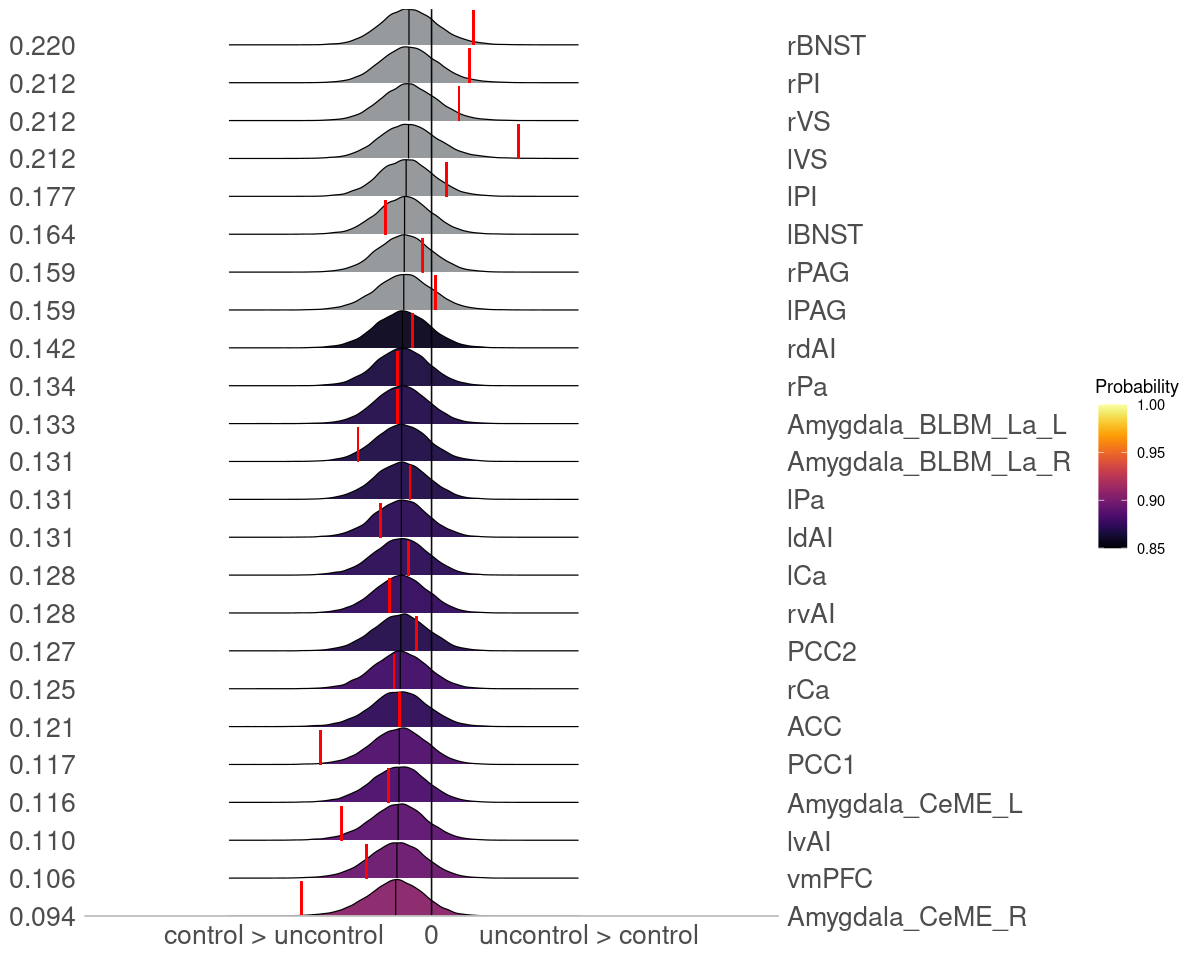

In [21]:
ii = 5
cat(sprintf('===== Summary of region effects for %s (RBA results) =====', EOIq[ii]), sep = '\n', append=TRUE)
ps0 <- psROI(aa, bb, EOIq[ii])
gg_brm <- sumROI(ps0, ns, nfigs)
#gg_brm$ROI <- factor(rownames(gg_brm))
cat(capture.output(gg_brm), sep = '\n', append=TRUE)

cat(sprintf('=================================================================================================================='),sep='\n')
cat(sprintf('===== Summary of region effects under GLM for %s (for reference only): no adjustment for multiplicity =====', EOIq[ii]),sep = '\n', append=TRUE)
mm <- list()
GLM <- as.formula(paste('Y ~ ',mod))
if(SCALE!=1) dataTable$Y <- (dataTable$Y)/SCALE  # scale back for GLM
for(kk in levels(dataTable$ROI)) mm[[kk]] = lm(GLM, data=dataTable[dataTable$ROI==kk,])
nn <- lapply(mm, summary)
ll <- lapply(nn, `[`, 'coefficients')
gg_glm <- sumGLM(ll, EOIq[ii], nR, nn[[ii]]$df, nfigs)
gg_glm = as.data.frame(gg_glm)
cat(capture.output(gg_glm),sep = '\n', append=TRUE)

cat(sprintf('======================================== Posteriors for %s ====================================================',EOIq[ii],sep='\n'))
plotPDP(ps0,gg_brm,gg_glm)

# **3. Posterior Predictive Check**

In [22]:
pp_plot = pp_check(fm,nsamples = 100)

Warning message:
“Removed 4391 rows containing non-finite values (stat_density).”
Warning message:
“Removed 44 rows containing non-finite values (stat_density).”


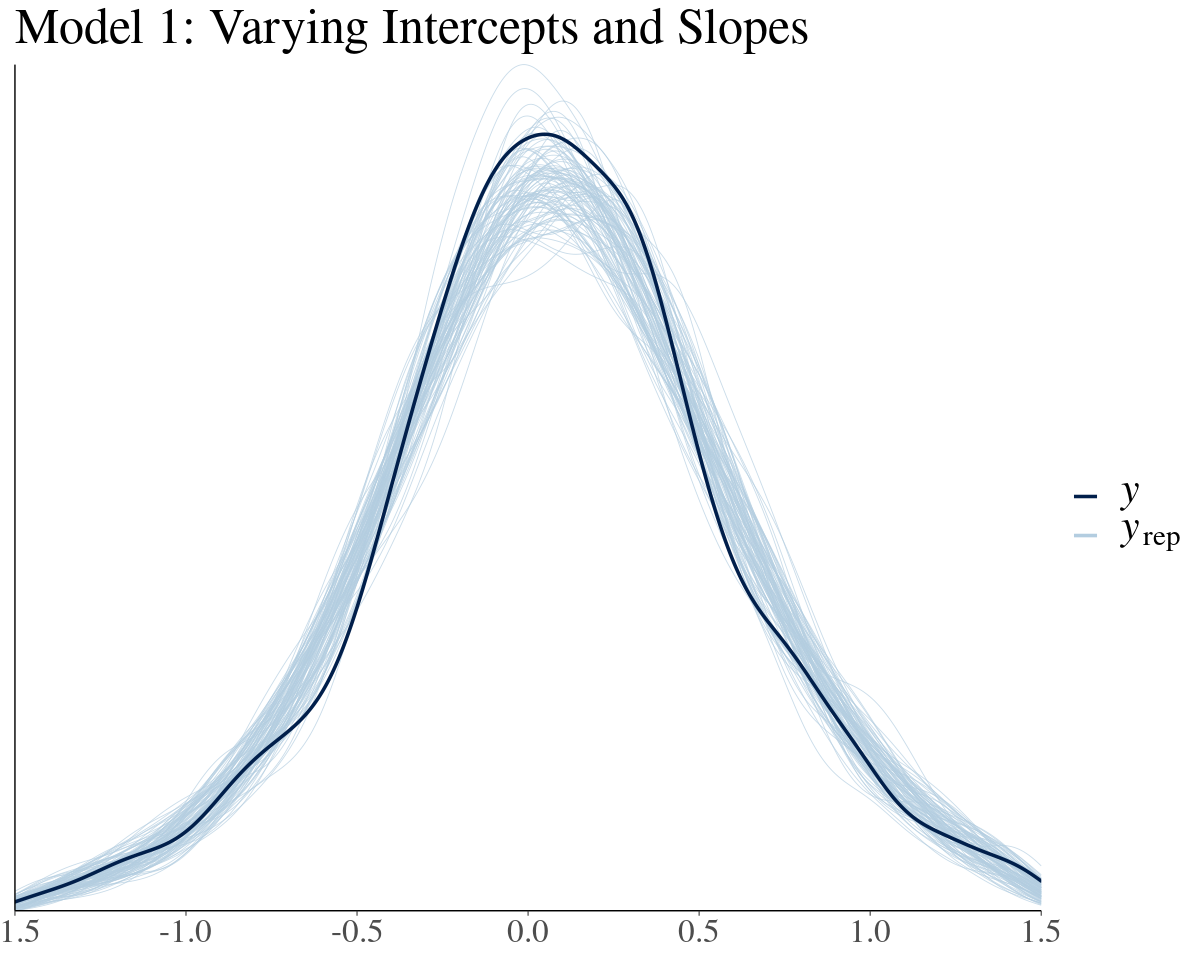

In [23]:
pp_plot + xlim(-1.5,1.5) + theme(text = element_text(size=25),legend.text=element_text(size=25)) + ggtitle("Model 1: Varying Intercepts and Slopes",)